# Question 4: [Strategy] Simple RSI-Based Trading Strategy

#0) Imports and Installs

In [1]:
#!pip install yfinance

In [3]:
# IMPORTS
import numpy as np
import pandas as pd
#import requests


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
#import plotly.graph_objs as go
#import plotly.express as px

#import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

# 1) [Code Snippet 1] IPOs data from Web

* learn dataframes "stacking" (UNION ALL)
* learn about type casting
* generate new columns (simple and with function)


In [ ]:
import pandas as pd
import requests
from io import StringIO

def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [ ]:
ipos_2023 = get_ipos_by_year(2023)
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      153 non-null    object
 1   Symbol        153 non-null    object
 2   Company Name  153 non-null    object
 3   IPO Price     153 non-null    object
 4   Current       153 non-null    object
 5   Return        153 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [ ]:
ipos_2024 = get_ipos_by_year(2024)
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      225 non-null    object
 1   Symbol        225 non-null    object
 2   Company Name  225 non-null    object
 3   IPO Price     225 non-null    object
 4   Current       225 non-null    object
 5   Return        225 non-null    object
dtypes: object(6)
memory usage: 10.7+ KB


In [ ]:
ipos_2025 = get_ipos_by_year(2025)
ipos_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      141 non-null    object
 1   Symbol        141 non-null    object
 2   Company Name  141 non-null    object
 3   IPO Price     141 non-null    object
 4   Current       141 non-null    object
 5   Return        141 non-null    object
dtypes: object(6)
memory usage: 6.7+ KB


In [ ]:
# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2025, ipos_2024, ipos_2023], ignore_index=True)

In [ ]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"May 30, 2025",PTNM,Pitanium Limited,$4.00,$3.80,-5.00%


In [ ]:
# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      519 non-null    object
 1   Symbol        519 non-null    object
 2   Company Name  519 non-null    object
 3   IPO Price     519 non-null    object
 4   Current       519 non-null    object
 5   Return        519 non-null    object
dtypes: object(6)
memory usage: 24.5+ KB


In [ ]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='mixed')

In [ ]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
60,2025-04-02,SORA,Top Win International Limited,-,$9.31,-
202,2024-10-11,STFS,Star Fashion Culture Holdings Limited,-,$1.26,-
261,2024-07-23,ZDAI,Primega Group Holdings Limited,-,$0.83,-
289,2024-05-31,NAKA,"Kindly MD, Inc.",-,$22.60,-


In [ ]:
# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

In [ ]:
# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

In [ ]:
# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      519 non-null    datetime64[ns]
 1   Symbol        519 non-null    object        
 2   Company Name  519 non-null    object        
 3   IPO Price     515 non-null    float64       
 4   Current       519 non-null    float64       
 5   Return        514 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 24.5+ KB


In [ ]:
# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()

,0
IPO Date,0
Symbol,0
Company Name,0
IPO Price,4
Current,0
Return,5


In [ ]:
# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
60,2025-04-02,SORA,Top Win International Limited,NaN,9.31,NaN
125,2025-01-22,DGNX,Diginex Limited,4.1,53.81,NaN
202,2024-10-11,STFS,Star Fashion Culture Holdings Limited,NaN,1.26,NaN
261,2024-07-23,ZDAI,Primega Group Holdings Limited,NaN,0.83,NaN
289,2024-05-31,NAKA,"Kindly MD, Inc.",NaN,22.60,NaN


In [ ]:
# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()

10.52864077669903

In [ ]:
# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']
stacked_ipos_df['Price Increase'].mean()

0.4604077669902913

In [ ]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase
0,2025-05-30,PTNM,Pitanium Limited,4.0,3.8,-0.05,-0.2


In [ ]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,519,515.000000,519.000000,514.000000,515.000000
mean,2024-05-31 19:08:40.231213824,10.528641,10.969865,-0.110756,0.460408
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999500,-38.010000
25%,2023-10-28 00:00:00,4.000000,1.700000,-0.721075,-3.510000
50%,2024-07-24 00:00:00,10.000000,7.870000,-0.100350,-0.700000
75%,2025-01-16 12:00:00,10.500000,10.830000,0.075750,0.710000
max,2025-05-30 00:00:00,92.000000,124.540000,6.532500,78.350000
std,NaN,9.777071,16.570354,0.847392,11.598651


In [ ]:
# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [ ]:
rddt_filter = stacked_ipos_df.Symbol=='RDDT'
stacked_ipos_df[rddt_filter]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase,Date_monthly
330,2024-03-21,RDDT,"Reddit, Inc.",34.0,112.35,2.3044,78.35,2024-03-01


In [ ]:
# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
ticker_obj = yf.Ticker("RDDT")
reddit = ticker_obj.history(period = "max", interval = "1d")

reddit.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-05-23 00:00:00-04:00,95.830002,102.264999,95.230003,100.760002,6753500,0.0,0.0
2025-05-27 00:00:00-04:00,103.000000,104.911003,99.139999,104.620003,6944400,0.0,0.0
2025-05-28 00:00:00-04:00,104.940002,106.707001,103.089996,105.430000,5399900,0.0,0.0
2025-05-29 00:00:00-04:00,108.190002,113.800003,107.594002,109.029999,10701400,0.0,0.0
2025-05-30 00:00:00-04:00,107.309998,112.620003,106.339996,112.349998,7540900,0.0,0.0


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

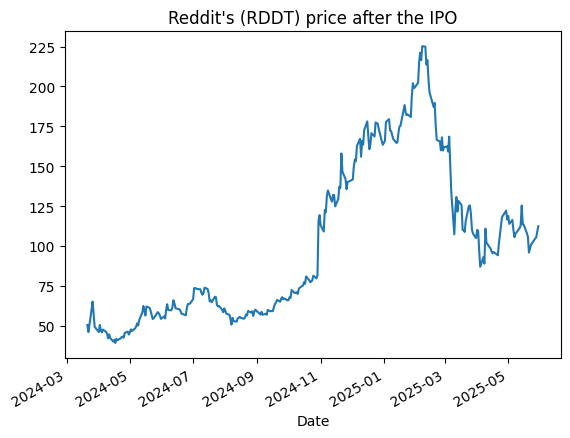

In [ ]:
reddit['Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

#2) OHLCV data transformations

## 2.1 [Code Snippet 2] Time series for OHLCV

In [ ]:
ticker_obj = yf.Ticker("NVO")
nvo_df = ticker_obj.history(period = "max", interval = "1d")

In [ ]:
# big plus of an API's data: good typing from the box!
# notice DatetimeIndex - it is a recognised date
nvo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11112 entries, 1981-04-30 00:00:00-04:00 to 2025-05-30 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11112 non-null  float64
 1   High          11112 non-null  float64
 2   Low           11112 non-null  float64
 3   Close         11112 non-null  float64
 4   Volume        11112 non-null  int64  
 5   Dividends     11112 non-null  float64
 6   Stock Splits  11112 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 694.5 KB


In [ ]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-05-23 00:00:00-04:00,67.260002,67.889999,66.599998,67.349998,6508400,0.0,0.0
2025-05-27 00:00:00-04:00,70.809998,71.300003,69.870003,70.440002,9250600,0.0,0.0
2025-05-28 00:00:00-04:00,69.379997,69.879997,68.360001,68.599998,7864700,0.0,0.0
2025-05-29 00:00:00-04:00,69.260002,69.500000,68.300003,69.459999,8993300,0.0,0.0
2025-05-30 00:00:00-04:00,69.790001,71.570000,69.070000,71.500000,11186300,0.0,0.0


In [ ]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

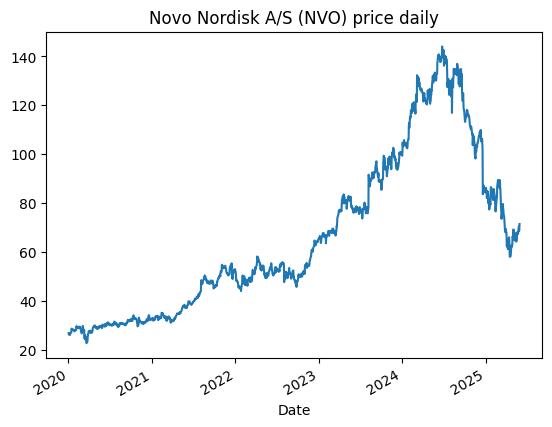

In [ ]:
# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')

In [ ]:
# generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins

In [ ]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,,
2025-05-23 00:00:00-04:00,67.260002,67.889999,66.599998,67.349998,6508400,0.0,0.0,NVO,2025,5,4,2025-05-23
2025-05-27 00:00:00-04:00,70.809998,71.300003,69.870003,70.440002,9250600,0.0,0.0,NVO,2025,5,1,2025-05-27
2025-05-28 00:00:00-04:00,69.379997,69.879997,68.360001,68.599998,7864700,0.0,0.0,NVO,2025,5,2,2025-05-28
2025-05-29 00:00:00-04:00,69.260002,69.500000,68.300003,69.459999,8993300,0.0,0.0,NVO,2025,5,3,2025-05-29
2025-05-30 00:00:00-04:00,69.790001,71.570000,69.070000,71.500000,11186300,0.0,0.0,NVO,2025,5,4,2025-05-30


In [ ]:
# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['close_minus_1'] = nvo_df['Close'].shift(-1)
nvo_df['close_plus_1'] = nvo_df['Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,close_minus_1,close_plus_1
Date,,,,,,,,,,,,,,
2025-05-23 00:00:00-04:00,67.260002,67.889999,66.599998,67.349998,6508400,0.0,0.0,NVO,2025,5,4,2025-05-23,70.440002,68.169998
2025-05-27 00:00:00-04:00,70.809998,71.300003,69.870003,70.440002,9250600,0.0,0.0,NVO,2025,5,1,2025-05-27,68.599998,67.349998
2025-05-28 00:00:00-04:00,69.379997,69.879997,68.360001,68.599998,7864700,0.0,0.0,NVO,2025,5,2,2025-05-28,69.459999,70.440002
2025-05-29 00:00:00-04:00,69.260002,69.500000,68.300003,69.459999,8993300,0.0,0.0,NVO,2025,5,3,2025-05-29,71.500000,68.599998
2025-05-30 00:00:00-04:00,69.790001,71.570000,69.070000,71.500000,11186300,0.0,0.0,NVO,2025,5,4,2025-05-30,NaN,69.459999


In [ ]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Close'] / nvo_df['Close'].shift(1)           # nvo_df['close_plus_1']
nvo_df['growth_30d'] = nvo_df['Close'] / nvo_df['Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Close'].shift(-1) / nvo_df['Close']   # nvo_df['close_minus_1']
nvo_df['growth_future_30d'] = nvo_df['Close'].shift(-30) / nvo_df['Close']   # nvo_df['close_minus_1']


# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)
nvo_df['is_positive_growth_30d_future'] = np.where(nvo_df['growth_future_30d'] > 1, 1, 0)


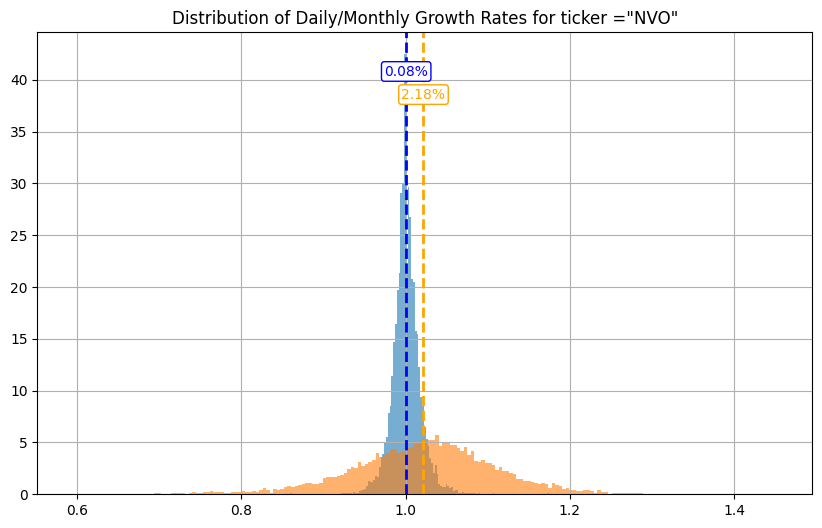

In [ ]:
# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.figure(figsize=(10, 6))
plt.title('Distribution of Daily/Monthly Growth Rates for ticker ="NVO"')

nvo_df.growth_1d.hist(bins=200, alpha=0.6, density=True)
nvo_df.growth_30d.hist(bins=200, alpha=0.6, density=True)

# Add vertical lines for averages
mean_1d = nvo_df.growth_1d.mean()
mean_30d = nvo_df.growth_30d.mean()

plt.axvline(mean_1d, color='blue', linestyle='--', linewidth=2, label=f'1d avg = {mean_1d:.3f}')
plt.axvline(mean_30d, color='orange', linestyle='--', linewidth=2, label=f'30d avg = {mean_30d:.3f}')


# Add mean text labels (as percent change)
ymax = plt.ylim()[1]
plt.text(mean_1d, ymax * 0.90,
         f'{(mean_1d - 1) * 100:.2f}%',
         color='blue', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.2'))

plt.text(mean_30d, ymax * 0.85,
         f'{(mean_30d - 1) * 100:.2f}%',
         color='orange', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.2'))


plt.show()

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

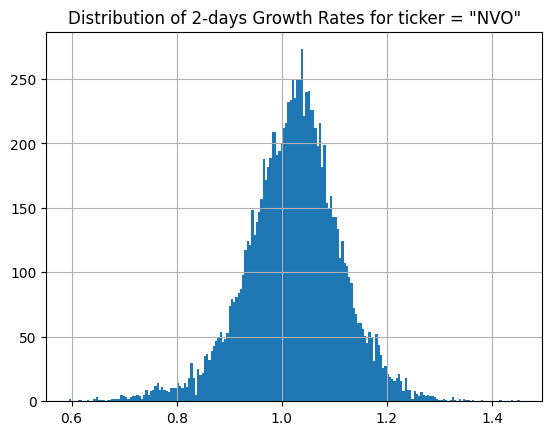

In [ ]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [ ]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Close']
nvo_df[COLUMNS].tail()

,Close,growth_1d,growth_30d,growth_future_1d,growth_future_30d,is_positive_growth_1d_future,is_positive_growth_30d_future
Date,,,,,,,
2025-05-23 00:00:00-04:00,67.349998,0.987971,1.100310,1.045880,NaN,1,0
2025-05-27 00:00:00-04:00,70.440002,1.045880,1.088213,0.973878,NaN,0,0
2025-05-28 00:00:00-04:00,68.599998,0.973878,1.038450,1.012536,NaN,1,0
2025-05-29 00:00:00-04:00,69.459999,1.012536,1.077066,1.029369,NaN,1,0
2025-05-30 00:00:00-04:00,71.500000,1.029369,1.137086,NaN,NaN,0,0


In [ ]:
# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)

,count
is_positive_growth_1d_future,
0,0.513049
1,0.486951


In [ ]:
nvo_df.is_positive_growth_30d_future.value_counts() / len(nvo_df)

,count
is_positive_growth_30d_future,
1,0.6196
0,0.3804


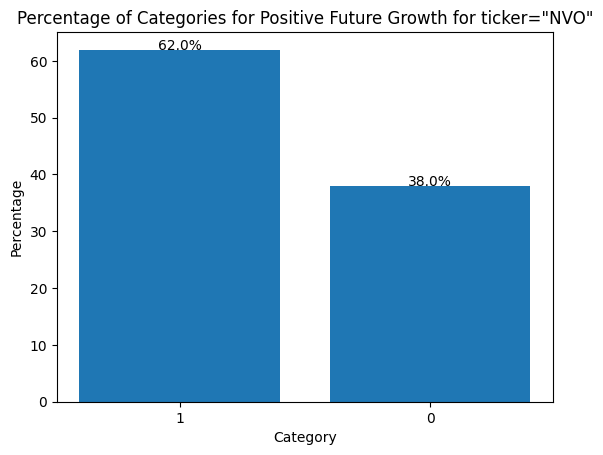

In [ ]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_30d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

## 2.2) [Code Snippet 6] Candlestick chart for OHLCV

In [ ]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

# 3) Macro Indicators

## 3.0) Previous indicators from module 1

In [35]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2025; month= 6; day=21
Period for indexes: 1955-06-21 to 2025-06-21 


In [36]:
# reuse code for ealier covered indicators
ticker_obj = yf.Ticker("^GDAXI")
dax_daily = ticker_obj.history(period = "max", interval = "1d")

In [37]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Close'] / dax_daily['Close'].shift(i)

In [38]:
dax_daily.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
1987-12-30 00:00:00+01:00,1005.190002,1005.190002,1005.190002,1005.190002,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04 00:00:00+01:00,956.489990,956.489990,956.489990,956.489990,0,0.0,0.0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05 00:00:00+01:00,996.099976,996.099976,996.099976,996.099976,0,0.0,0.0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06 00:00:00+01:00,1006.010010,1006.010010,1006.010010,1006.010010,0,0.0,0.0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07 00:00:00+01:00,1014.469971,1014.469971,1014.469971,1014.469971,0,0.0,0.0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [39]:
dax_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
2025-06-19 00:00:00+02:00,23178.599609,23254.859375,23051.550781,23057.380859,41395300,0.0,0.0,0.988831,0.972921,0.961222,0.987354,1.052284,1.381524
2025-06-20 00:00:00+02:00,23197.119141,23481.970703,23187.480469,23350.550781,153406000,0.0,0.0,1.012715,0.996411,0.975016,0.993669,1.059567,1.411163


In [40]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-20 00:00:00+02:00,1.012715,0.996411,0.975016,0.993669,1.059567,1.411163


In [41]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Close'] / df['Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [42]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
ticker_obj = yf.Ticker("^GSPC")

# snp500_daily = yf.download(tickers = "^GSPC",
#                      period = "max",
#                      interval = "1d")

snp500_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [43]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,0.999691,1.000652,0.995836,1.066696,0.992512,1.271225
2025-06-20 00:00:00-04:00,0.997821,0.989181,0.988248,1.059766,0.983747,1.272819


In [44]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch

ticker_obj = yf.Ticker("^DJI")

# dji_daily = yf.download(tickers = "^DJI",
#                      period = "max",
#                      interval = "1d")


dji_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [45]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)

,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,0.998954,0.999381,0.986200,1.032885,0.951883,1.126675
2025-06-20 00:00:00-04:00,1.000834,0.992749,0.984602,1.026581,0.949099,1.127309


In [46]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI

# epi_etf_daily = yf.download(tickers = "EPI",
#                      period = "max",
#                      interval = "1d")

ticker_obj = yf.Ticker("EPI")
epi_etf_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

epi_etf_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-06-18 00:00:00-04:00,45.869999,45.970001,45.770000,45.880001,720200,0.0,0.0,0.0
2025-06-20 00:00:00-04:00,46.090000,46.110001,45.849998,45.880001,963900,0.0,0.0,0.0


In [47]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,0.998477,0.991571,0.975755,1.010795,1.064995,1.123070
2025-06-20 00:00:00-04:00,1.000000,0.985395,0.972240,1.020236,1.063761,1.114634


In [48]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2025-01-01,23243.22,0.023113,0.005619
2025-04-01,23376.07,0.023029,0.005716


In [49]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [50]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)

,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2025-04-01,326.430,0.027815,0.002368
2025-05-01,326.854,0.027671,0.001299


In [51]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-04-01,0.027815,0.002368
2025-05-01,0.027671,0.001299


In [52]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

,FEDFUNDS
DATE,
2025-04-01,4.33
2025-05-01,4.33


In [53]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

,DGS1
DATE,
2025-06-17,4.1
2025-06-18,4.1


In [54]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2025-06-17,3.99
2025-06-18,3.98


In [55]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)

,DGS10
DATE,
2025-06-17,4.39
2025-06-18,4.38


## 3.1) [Code snippet 3] VIX - Volatility Index

In [56]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/

ticker_obj = yf.Ticker("^VIX")

# vix = yf.download(tickers = "^VIX",
#                      period = "max",
#                      interval = "1d")

vix = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [57]:
vix.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-18 00:00:00-05:00,20.90,21.58,19.590000,20.139999,0,0.0,0.0
2025-06-20 00:00:00-05:00,20.74,21.07,19.110001,20.620001,0,0.0,0.0


In [58]:
vix_to_merge = vix['Close']
vix_to_merge.tail()

Date
2025-06-13 00:00:00-05:00    20.820000
2025-06-16 00:00:00-05:00    19.110001
2025-06-17 00:00:00-05:00    21.600000
2025-06-18 00:00:00-05:00    20.139999
2025-06-20 00:00:00-05:00    20.620001
Name: Close, dtype: float64

<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

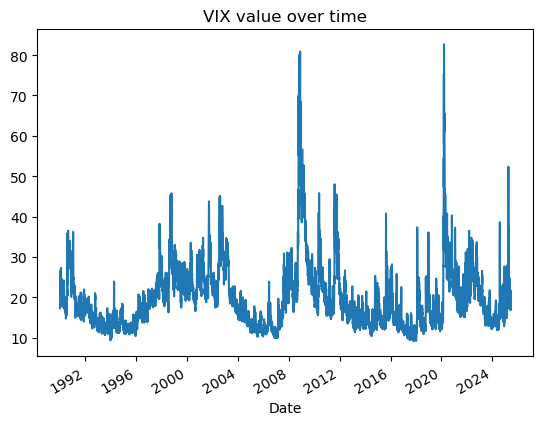

In [59]:
# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Close'].plot.line(title = "VIX value over time")

In [60]:
# Dynamic visualisation of VIX prices
#fig = px.line(vix,
#              x=vix.index,
#              y="Close",
#              title='VIX over time')
#fig.update_layout(title_x=0.5)  # This will center the title horizontally

#fig.show()

## 3.2) Gold - other assets

In [61]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF

ticker_obj = yf.Ticker("GC=F")

# gold = yf.download(tickers = "GC=F",
#                      period = "max",
#                      interval = "1d")

gold = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [62]:
gold.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-20 00:00:00-04:00,3350.0,3372.899902,3341.0,3368.100098,0,0.0,0.0


In [63]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,1.000945,0.987934,1.017316,0.993668,1.182227,1.659795
2025-06-20 00:00:00-04:00,0.993598,0.991668,1.014213,0.996067,1.155715,1.649089


In [65]:
# Dynamic visualisation of GOLD prices
# fig = px.line(gold,
#               x=gold.index,
#               y="Close",
#               title='GOLD over time')
# fig.update_layout(title_x=0.5)  # This will center the title horizontally

#fig.show()

## 3.3) WTI Crude and Brent Oil

In [66]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/

ticker_obj = yf.Ticker("CL=F")

# crude_oil = yf.download(tickers = "CL=F",
#                      period = "max",
#                      interval = "1d")

crude_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [67]:
crude_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-18 00:00:00-04:00,75.610001,76.070000,72.940002,75.139999,0,0.0,0.0
2025-06-20 00:00:00-04:00,74.599998,77.580002,74.300003,74.930000,0,0.0,0.0


In [68]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,1.004009,1.029597,1.150865,1.271620,1.05831,1.040864
2025-06-20 00:00:00-04:00,0.997205,1.044030,1.153124,1.290339,1.03609,1.015174


In [69]:
# Dynamic visualisation
# fig = px.line(crude_oil,
#               x=crude_oil.index,
#               y="Close",
#               title='WTI Crude Oil over time')
# fig.update_layout(title_x=0.5)  # This will center the title horizontally

# fig.show()

In [70]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/

ticker_obj = yf.Ticker("BZ=F")

# brent_oil = yf.download(tickers = "BZ=F",
#                      period = "max",
#                      interval = "1d")

brent_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-18 00:00:00-04:00,77.190002,77.430000,74.440002,76.699997,0,0.0,0.0
2025-06-20 00:00:00-04:00,76.120003,79.019997,75.529999,77.010002,0,0.0,0.0


In [71]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,1.003270,1.033275,1.144093,1.234111,1.027324,0.988529
2025-06-20 00:00:00-04:00,1.004042,1.051618,1.151637,1.259980,1.015026,0.977781


In [72]:
# Dynamic visualisation
# fig = px.line(brent_oil,
#               x=brent_oil.index,
#               y="Close",
#               title='Brent Oil over time')
# fig.update_layout(title_x=0.5)  # This will center the title horizontally

# fig.show()


## 3.4) Bitcoin prices: BTC_USD

In [73]:
# https://finance.yahoo.com/quote/BTC-USD/

ticker_obj = yf.Ticker("BTC-USD")

# btc_usd =  yf.download(tickers = "BTC-USD",
#                      period = "max",
#                      interval = "1d")


btc_usd =  ticker_obj.history(
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-20 00:00:00+00:00,104681.031250,106539.382812,102372.210938,103309.601562,50951862476,0.0,0.0
2025-06-21 00:00:00+00:00,103309.835938,104008.515625,103009.843750,103009.843750,32672192512,0.0,0.0


In [74]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2025-06-20 00:00:00+00:00,0.986868,0.987653,0.973783,0.941935,1.232334,1.593579
2025-06-21 00:00:00+00:00,0.997098,0.982137,0.976652,0.922422,1.197032,1.607113


In [75]:
# Dynamic visualisation
# fig = px.line(btc_usd,
#               x=btc_usd.index,
#               y="Close",
#               title='Bitcoin price daily')
# fig.update_layout(title_x=0.5)  # This will center the title horizontally

# fig.show()


## 3.5 [Code snippet 4] Eurostat: "The home of high-quality statistics and data on Europe"


In [76]:
!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database

In [77]:
import eurostat

In [78]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2025-05-01', 'endPeriod':'2025-06-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [79]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freq              2148 non-null   object 
 1   yld_curv          2148 non-null   object 
 2   maturity          2148 non-null   object 
 3   bonds             2148 non-null   object 
 4   geo\TIME_PERIOD   2148 non-null   object 
 5   2025-05-02_value  2148 non-null   float64
 6   2025-05-02_flag   2148 non-null   object 
 7   2025-05-05_value  2148 non-null   float64
 8   2025-05-05_flag   2148 non-null   object 
 9   2025-05-06_value  2148 non-null   float64
 10  2025-05-06_flag   2148 non-null   object 
 11  2025-05-07_value  2148 non-null   float64
 12  2025-05-07_flag   2148 non-null   object 
 13  2025-05-08_value  2148 non-null   float64
 14  2025-05-08_flag   2148 non-null   object 
 15  2025-05-09_value  2148 non-null   float64
 16  2025-05-09_flag   2148 non-null   object 


In [80]:
eurostat_euro_yield_df.head()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,


In [81]:
eurostat_euro_yield_df['bonds'].value_counts()

bonds
CGB_EA        1074
CGB_EA_AAA    1074
Name: count, dtype: int64

In [82]:
eurostat_euro_yield_df['maturity'].value_counts()


maturity
M10       6
Y26_M8    6
Y28_M4    6
Y28_M3    6
Y28_M2    6
         ..
Y18_M9    6
Y18_M8    6
Y18_M7    6
Y18_M6    6
Y9_M9     6
Name: count, Length: 358, dtype: int64

In [83]:
eurostat_euro_yield_df['yld_curv'].value_counts()

yld_curv
INS_FWD    716
PAR        716
SPOT_RT    716
Name: count, dtype: int64

In [84]:
eurostat_euro_yield_df

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.56000,,2.58380,,2.61680,...,2.63569,,2.60094,,2.61034,,2.57690,,2.57548,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.09194,,3.11837,,3.15733,...,3.13756,,3.09442,,3.10789,,3.06678,,3.07015,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.56737,,2.59130,,2.62451,...,2.64314,,2.60802,,2.61738,,2.58400,,2.58254,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.10140,,3.12818,,3.16710,...,3.14705,,3.10358,,3.11705,,3.07587,,3.07933,


In [85]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [86]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-05_value']].head(20)

,maturity,2025-05-05_value
1433,M10,1.79463
1435,M11,1.78389
1437,M3,1.91227
1439,M4,1.89037
1441,M5,1.87031
1443,M6,1.85200
1445,M7,1.83535
1447,M8,1.82029
1449,M9,1.80674
1451,Y1,1.77444


In [87]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-29_value']].head(20)

,maturity,2025-05-29_value
1433,M10,1.78884
1435,M11,1.78214
1437,M3,1.86951
1439,M4,1.85393
1441,M5,1.83981
1443,M6,1.82708
1445,M7,1.81569
1447,M8,1.80555
1449,M9,1.79662
1451,Y1,1.77647


In [88]:
import re

def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [89]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

In [90]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2025-05-29_value']].head(20)

,maturity,maturity_in_months,2025-05-29_value
1437,M3,3,1.86951
1439,M4,4,1.85393
1441,M5,5,1.83981
1443,M6,6,1.82708
1445,M7,7,1.81569
1447,M8,8,1.80555
1449,M9,9,1.79662
1433,M10,10,1.78884
1435,M11,11,1.78214
1451,Y1,12,1.77647


In [91]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

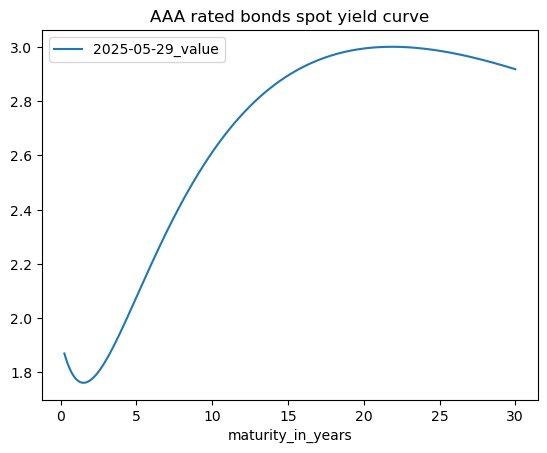

In [92]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2025-05-29_value']] \
  .plot.line(x='maturity_in_years',
            y='2025-05-29_value',
            title='AAA rated bonds spot yield curve')

# 4) [Code Snippet 5] Fundamental indicators

* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/

In [ ]:
# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)

In [ ]:
# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
# WMT ticker
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings

,EPS Estimate,Reported EPS,Surprise(%),Ticker
Earnings Date,,,,
2026-05-13 09:30:00-04:00,NaN,NaN,NaN,WMT
2026-02-19 09:30:00-05:00,NaN,NaN,NaN,WMT
2025-11-20 09:30:00-05:00,NaN,NaN,NaN,WMT
2025-08-21 09:30:00-04:00,NaN,NaN,NaN,WMT
2025-05-15 07:01:00-04:00,0.58,0.61,5.93,WMT
2025-02-20 06:59:00-05:00,0.64,0.66,2.57,WMT
2024-11-19 07:00:00-05:00,0.53,0.58,8.82,WMT
2024-08-15 07:02:00-04:00,0.65,0.67,3.78,WMT
2024-05-16 07:01:00-04:00,0.52,0.60,14.60,WMT


In [ ]:
one_company.calendar

{'Dividend Date': datetime.date(2026, 1, 5),
 'Ex-Dividend Date': datetime.date(2025, 8, 15),
 'Earnings Date': [datetime.date(2025, 8, 21)],
 'Earnings High': 0.8,
 'Earnings Low': 0.67,
 'Earnings Average': 0.7236,
 'Revenue High': 176653000000,
 'Revenue Low': 172272000000,
 'Revenue Average': 174049148760}

In [ ]:
one_company.financials

,2025-01-31,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,-612140000.0,NaN
Tax Rate For Calcs,0.234,0.255,0.336,0.254,NaN
Normalized EBITDA,42010000000.0,36384000000.0,30089000000.0,33758000000.0,NaN
Total Unusual Items,NaN,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,NaN,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,19436000000.0,15511000000.0,11680000000.0,13673000000.0,NaN
Reconciled Depreciation,12973000000.0,11853000000.0,10945000000.0,10658000000.0,NaN
Reconciled Cost Of Revenue,511753000000.0,490142000000.0,463721000000.0,429000000000.0,NaN
EBITDA,42010000000.0,36384000000.0,30089000000.0,31348000000.0,NaN
EBIT,29037000000.0,24531000000.0,19144000000.0,20690000000.0,NaN


In [ ]:
EPS = one_company.financials.loc['Basic EPS']
EPS

,Basic EPS
2025-01-31,2.42
2024-01-31,1.92
2023-01-31,1.43
2022-01-31,1.633333
2021-01-31,NaN


In [ ]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']

In [ ]:
EBITDA_margin

,0
2025-01-31,0.06169
2024-01-31,0.056137
2023-01-31,0.049222
2022-01-31,0.054732
2021-01-31,NaN


In [ ]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']

In [ ]:
NET_INCOME

,Net Income
2025-01-31,19436000000.0
2024-01-31,15511000000.0
2023-01-31,11680000000.0
2022-01-31,13673000000.0
2021-01-31,NaN


In [ ]:
# Compare with Public information - you can fully replicate the numbers (yearly and/or quarterly):
# https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement
NET_INCOME_margin

,0
2025-01-31,0.028541
2024-01-31,0.023932
2023-01-31,0.019107
2022-01-31,0.023872
2021-01-31,NaN


In [ ]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

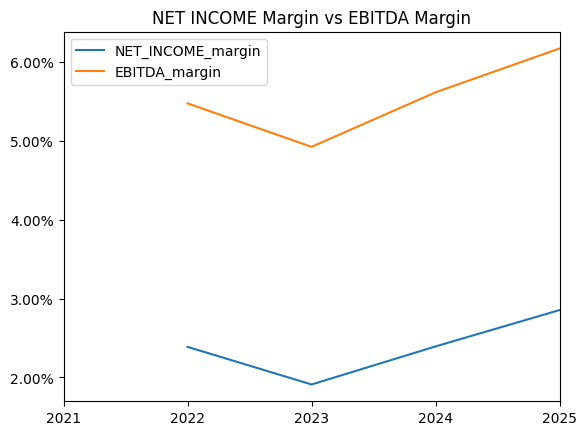

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()

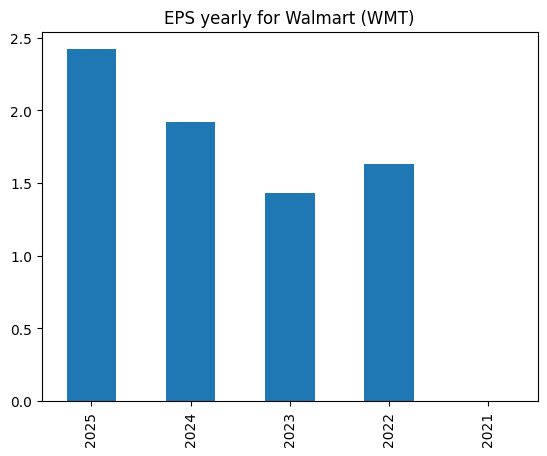

In [ ]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()

# 5) [Code snippet 7] Daily OHCLV data for a set of stocks

In [7]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [8]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS

['MSFT',
 'AAPL',
 'GOOG',
 'NVDA',
 'AMZN',
 'META',
 'BRK-B',
 'LLY',
 'AVGO',
 'V',
 'JPM',
 'NVO',
 'MC.PA',
 'ASML',
 'RMS.PA',
 'OR.PA',
 'SAP',
 'ACN',
 'TTE',
 'SIE.DE',
 'IDEXY',
 'CDI.PA',
 'RELIANCE.NS',
 'TCS.NS',
 'HDB',
 'BHARTIARTL.NS',
 'IBN',
 'SBIN.NS',
 'LICI.NS',
 'INFY',
 'ITC.NS',
 'HINDUNILVR.NS',
 'LT.NS']

In [9]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT
1 AAPL
2 GOOG
3 NVDA
4 AMZN
5 META
6 BRK-B
7 LLY
8 AVGO
9 V
10 JPM
11 NVO
12 MC.PA
13 ASML
14 RMS.PA
15 OR.PA
16 SAP
17 ACN
18 TTE
19 SIE.DE
20 IDEXY
21 CDI.PA
22 RELIANCE.NS
23 TCS.NS
24 HDB
25 BHARTIARTL.NS
26 IBN
27 SBIN.NS
28 LICI.NS
29 INFY
30 ITC.NS
31 HINDUNILVR.NS
32 LT.NS


In [10]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'


In [11]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [12]:
# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

ticker_type
US       83808
EU       80182
INDIA    66417
Name: count, dtype: int64

In [13]:
# unique tickers
stocks_df.Ticker.nunique()

33

In [14]:
# count of observations by stock
stocks_df.Ticker.value_counts()

Ticker
LLY              13375
JPM              11409
AAPL             11221
NVO              11126
MSFT              9895
CDI.PA            8615
TTE               8473
ASML              7618
SAP               7489
HINDUNILVR.NS     7401
SBIN.NS           7399
RELIANCE.NS       7398
ITC.NS            7398
SIE.DE            7331
BRK-B             7326
AMZN              7069
NVDA              6644
INFY              6611
MC.PA             6545
RMS.PA            6545
OR.PA             6545
IBN               6346
ACN               6016
HDB               6015
LT.NS             5706
BHARTIARTL.NS     5703
TCS.NS            5674
GOOG              5243
V                 4342
AVGO              3993
IDEXY             3879
META              3291
LICI.NS            766
Name: count, dtype: int64

In [15]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

,,min,max
Ticker,ticker_type,,
AAPL,US,1980-12-12,2025-06-20
ACN,EU,2001-07-19,2025-06-20
AMZN,US,1997-05-15,2025-06-20
ASML,EU,1995-03-15,2025-06-20
AVGO,US,2009-08-06,2025-06-20
BHARTIARTL.NS,INDIA,2002-07-01,2025-06-20
BRK-B,US,1996-05-09,2025-06-20
CDI.PA,EU,1992-01-27,2025-06-20
GOOG,US,2004-08-19,2025-06-20


In [16]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.245388
      INDIA          1.100694
      US             1.484070
2021  EU             1.582166
      INDIA          1.545740
      US             1.797571
2022  EU             1.191167
      INDIA          1.379738
      US             1.182379
2023  EU             1.246532
      INDIA          1.201678
      US             1.203253
2024  EU             1.406426
      INDIA          1.353950
      US             2.159361
2025  EU             1.165693
      INDIA          1.215587
      US             1.668734
Name: growth_365d, dtype: float64

In [17]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [18]:
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191940 entries, 3490 to 230406
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           191940 non-null  float64       
 1   High                           191940 non-null  float64       
 2   Low                            191940 non-null  float64       
 3   Close                          191940 non-null  float64       
 4   Volume                         191940 non-null  int64         
 5   Dividends                      191940 non-null  float64       
 6   Stock Splits                   191940 non-null  float64       
 7   Ticker                         191940 non-null  object        
 8   Year                           191940 non-null  int32         
 9   Month                          191940 non-null  int32         
 10  Weekday                        191940 non-null  int32         
 11  Da

In [19]:
stocks_df[stocks_df.Date=='2025-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_90d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future,ticker_type
203236,795.000000,806.000000,792.099976,797.750000,726877,0.0,0.0,LICI.NS,2025,4,...,0.904530,1.249596,1.071827,786.810004,767.930005,1,0.017424,337.725353,1,INDIA
209846,18.190001,18.209999,17.950001,18.200001,13574900,0.0,0.0,INFY,2025,4,...,0.842593,1.105543,1.014286,18.432000,18.730500,0,0.014286,17.068021,1,INDIA
217245,402.386004,406.902788,398.262008,399.292999,15206240,0.0,0.0,ITC.NS,2025,4,...,0.903574,0.964762,1.070577,400.068704,398.897778,1,0.021640,69.909597,1,INDIA
224646,2259.000000,2284.649902,2220.000000,2233.850098,2495962,0.0,0.0,HINDUNILVR.NS,2025,4,...,0.937490,0.915983,1.066634,2237.069995,2215.125000,1,0.028941,691.003186,1,INDIA
230352,3447.844234,3469.244743,3398.306242,3405.043457,1935147,0.0,0.0,LT.NS,2025,4,...,0.986594,1.119635,1.047544,3377.198193,3277.881909,1,0.020833,1726.860104,1,INDIA


#6) [Code Snippet 8] Technical Indicators with TA-lib
* PythonInvest article on Tech. Indicators
* Code for generating 100+ tech. indicators/patterns : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md

* Overlap Studies (17)
* Momentum Indicators (30+)
* Volume Indicators (3)
* Cycle Indicators (5)
* Price Transform (4)
* Volatility Indicators (3)
* Pattern Recognition (60)

In [20]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
# import talib

In [21]:
# [2025 way - seems to be working] https://medium.com/@Tobi_Lux/collaboration-of-colab-yfinance-and-ta-lib-recent-issues-6cd8eebb56b0
#url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
#!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
#!pip install conda-package-handling
#!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
#!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda

# 🛠 Option 1: Remove the existing directory first (clean, but destructive)
#!rm -rf /usr/local/lib/python3.11/dist-packages/talib

#!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

## 6.1) Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [22]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

## 6.2 Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [23]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

## 6.3) Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [24]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

## 6.4) Calculate Tech Indicators and Merge to the original dataframe

In [25]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [26]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [27]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230407 entries, 0 to 230406
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           230407 non-null  float64       
 1   High                           230407 non-null  float64       
 2   Low                            230407 non-null  float64       
 3   Close                          230407 non-null  float64       
 4   Volume                         230407 non-null  float64       
 5   Dividends                      230407 non-null  float64       
 6   Stock Splits                   230407 non-null  float64       
 7   Ticker                         230407 non-null  object        
 8   Year                           230407 non-null  int32         
 9   Month                          230407 non-null  int32         
 10  Weekday                        230407 non-null  int32         
 11  

In [28]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [29]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
463,919.998455,979.127016,919.003862,965.351868,4863536.0,0.0,0.0,LICI.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
6304,17.336117,17.365189,16.958192,17.035715,14601600.0,0.0,0.0,INFY,2024,4,...,0,0,0,0,0,0,0,0,0,0
7095,407.560834,409.697893,404.378986,405.281311,9382308.0,0.0,0.0,ITC.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
7098,2231.156837,2255.729049,2223.293729,2246.784668,1427873.0,0.0,0.0,HINDUNILVR.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
5403,3716.697971,3786.493268,3716.697971,3772.878174,1905190.0,0.0,0.0,LT.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0


In [30]:
merged_df_with_tech_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230407 entries, 0 to 5705
Columns: 145 entries, Open to cdlxsidegap3methods
dtypes: datetime64[ns, UTC](1), float64(72), int32(67), int64(3), object(2)
memory usage: 197.8+ MB


# 7) [Code snippet 9] Merge All Together

In [31]:
merged_df_with_tech_ind.head(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,3,...,0,0,0,0,0,0,0,0,0,0


In [32]:
merged_df_with_tech_ind.shape

(230407, 145)

In [33]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

In [93]:
# merge with dax_daily_to_merge
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-20 00:00:00+02:00,1.012715,0.996411,0.975016,0.993669,1.059567,1.411163


In [94]:
dax_daily_to_merge.index = dax_daily_to_merge.index.tz_localize(None)

In [95]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [96]:
m2.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
5705,3614.0,3669.899902,3614.0,3662.0,2575277.0,0.0,0.0,LT.NS,2025,6,...,0,0,0,0,1.012715,0.996411,0.975016,0.993669,1.059567,1.411163


In [97]:
# check the same number of records, but columns increased
m2.shape

(230407, 151)

In [98]:
# merge with dax_daily_to_merge
snp500_to_merge.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-20 00:00:00-04:00,0.997821,0.989181,0.988248,1.059766,0.983747,1.272819


In [99]:
snp500_to_merge.index = snp500_to_merge.index.tz_localize(None)

In [100]:
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [101]:
m3.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
5705,3614.0,3669.899902,3614.0,3662.0,2575277.0,0.0,0.0,LT.NS,2025,6,...,0.975016,0.993669,1.059567,1.411163,0.997821,0.989181,0.988248,1.059766,0.983747,1.272819


In [102]:
m3.shape

(230407, 157)

In [103]:
dji_daily_to_merge.index = dji_daily_to_merge.index.tz_localize(None)

In [104]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [105]:
m4.shape

(230407, 163)

In [106]:
m4.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
5705,3614.0,3669.899902,3614.0,3662.0,2575277.0,0.0,0.0,LT.NS,2025,6,...,0.988248,1.059766,0.983747,1.272819,1.000834,0.992749,0.984602,1.026581,0.949099,1.127309


In [107]:
epi_etf_daily_to_merge.index = epi_etf_daily_to_merge.index.tz_localize(None)

In [108]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [109]:
m5.shape

(230407, 169)

In [110]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

0      1986-01-01
1      1986-01-01
2      1986-01-01
3      1986-01-01
4      1986-01-01
          ...    
5701   2025-04-01
5702   2025-04-01
5703   2025-04-01
5704   2025-04-01
5705   2025-04-01
Name: Quarter, Length: 230407, dtype: datetime64[ns]

In [111]:
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [112]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [113]:
m6.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_dji_365d,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,6,...,1.127309,1.0,0.985395,0.97224,1.020236,1.063761,1.114634,2025-04-01,0.023029,0.005716


In [114]:
m6.shape

(230407, 172)

In [115]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m6['Month']

0      1986-03-01
1      1986-03-01
2      1986-03-01
3      1986-03-01
4      1986-03-01
          ...    
5701   2025-06-01
5702   2025-06-01
5703   2025-06-01
5704   2025-06-01
5705   2025-06-01
Name: Month, Length: 230407, dtype: datetime64[ns]

In [116]:
cpilfesl_to_merge.tail(1)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-05-01,0.027671,0.001299


In [117]:
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [118]:
# PROBLEM! Last month is not defined
m7.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5705,3614.0,3669.899902,3614.0,3662.0,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,0.985395,0.97224,1.020236,1.063761,1.114634,2025-04-01,0.023029,0.005716,NaN,NaN


In [119]:
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].ffill()


In [120]:
m7.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5705,3614.0,3669.899902,3614.0,3662.0,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,0.985395,0.97224,1.020236,1.063761,1.114634,2025-04-01,0.023029,0.005716,0.027671,0.001299


In [121]:
fedfunds.tail(1)

,FEDFUNDS
DATE,
2025-05-01,4.33


In [122]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [123]:
m8.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5705,3614.0,3669.899902,3614.0,3662.0,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,0.97224,1.020236,1.063761,1.114634,2025-04-01,0.023029,0.005716,0.027671,0.001299,NaN


In [124]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].ffill()


In [125]:
m8.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5705,3614.0,3669.899902,3614.0,3662.0,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,0.97224,1.020236,1.063761,1.114634,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33


In [126]:
dgs1.tail(1)

,DGS1
DATE,
2025-06-18,4.1


In [127]:
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [128]:
# fix last day later
m9.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.020236,1.063761,1.114634,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN


In [129]:
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [130]:
# fix last day later
m10.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.063761,1.114634,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN


In [131]:
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [132]:
m11.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.114634,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN


In [133]:
vix_to_merge

Date
1990-01-02 00:00:00-06:00    17.240000
1990-01-03 00:00:00-06:00    18.190001
1990-01-04 00:00:00-06:00    19.219999
1990-01-05 00:00:00-06:00    20.110001
1990-01-08 00:00:00-06:00    20.260000
                               ...    
2025-06-13 00:00:00-05:00    20.820000
2025-06-16 00:00:00-05:00    19.110001
2025-06-17 00:00:00-05:00    21.600000
2025-06-18 00:00:00-05:00    20.139999
2025-06-20 00:00:00-05:00    20.620001
Name: Close, Length: 8933, dtype: float64

In [134]:
vix_to_merge.index = vix_to_merge.index.tz_localize(None)

In [135]:
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [136]:
m12.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10,Close_y
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN,NaN
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN,20.620001


In [137]:
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-18 00:00:00-04:00,1.000945,0.987934,1.017316,0.993668,1.182227,1.659795
2025-06-20 00:00:00-04:00,0.993598,0.991668,1.014213,0.996067,1.155715,1.649089


In [138]:
gold_to_merge.index = gold_to_merge.index.tz_localize(None)

In [139]:
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [140]:
m13.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,DGS1,DGS5,DGS10,Close_y,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,20.620001,0.993598,0.991668,1.014213,0.996067,1.155715,1.649089


In [141]:
crude_oil_to_merge.index = crude_oil_to_merge.index.tz_localize(None)

In [142]:
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [143]:
m14.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.014213,0.996067,1.155715,1.649089,0.997205,1.04403,1.153124,1.290339,1.03609,1.015174


In [144]:
brent_oil_to_merge.index = brent_oil_to_merge.index.tz_localize(None)

In [145]:
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [146]:
m15.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.153124,1.290339,1.03609,1.015174,1.004042,1.051618,1.151637,1.25998,1.015026,0.977781


In [147]:
btc_usd_to_merge.index = btc_usd_to_merge.index.tz_localize(None)

In [148]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [149]:
m16.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,0.998102,0.980220,0.988249,0.980272,1.245600,1.611512
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.151637,1.25998,1.015026,0.977781,0.986868,0.987653,0.973783,0.941935,1.232334,1.593579


In [150]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].ffill()

In [151]:
m16.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5704,3607.0,3643.000000,3591.100098,3621.100098,1580819.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,0.998102,0.980220,0.988249,0.980272,1.245600,1.611512
5705,3614.0,3669.899902,3614.000000,3662.000000,2575277.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.151637,1.25998,1.015026,0.977781,0.986868,0.987653,0.973783,0.941935,1.232334,1.593579


In [152]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230407 entries, 0 to 5705
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(66), int64(3), object(2)
memory usage: 300.6+ MB


In [153]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

2025_06_20


In [154]:
m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')